# 1. Import Libraries


In [39]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve,confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

#2. Load Dataset


In [40]:
df = pd.read_csv('credit_score.csv') # Replace with actual path


# Drop ID column


In [41]:
X = df.drop(columns=["CUST_ID", "DEFAULT"])
y = df["DEFAULT"]


# One-hot encode categorical features


In [42]:
X = pd.get_dummies(X, drop_first=True)


# Split the data


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# Scale the data


In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Calculate scale_pos_weight for imbalance handling


In [45]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Train XGBoost Classifier


In [46]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:06:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

# Predict


In [47]:
y_pred = xgb_model.predict(X_test_scaled)
y_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]


# Evaluation




In [48]:
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))



Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.83      0.79       143
           1       0.46      0.37      0.41        57

    accuracy                           0.69       200
   macro avg       0.61      0.60      0.60       200
weighted avg       0.68      0.69      0.68       200

ROC AUC Score: 0.6351367930315298


# Plot ROC Curve


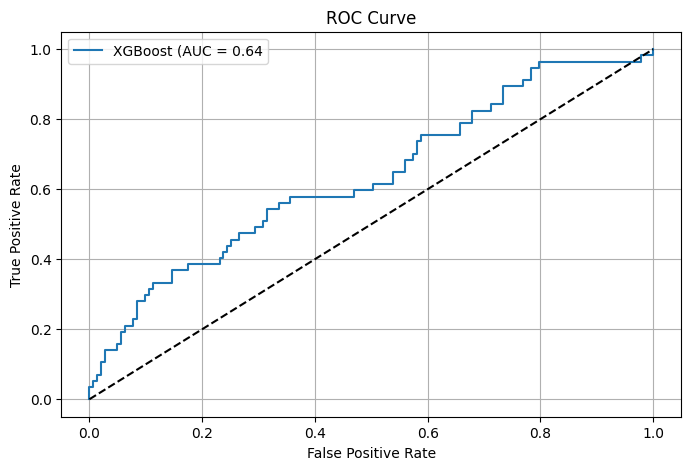

In [49]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


# Confusion Matrix


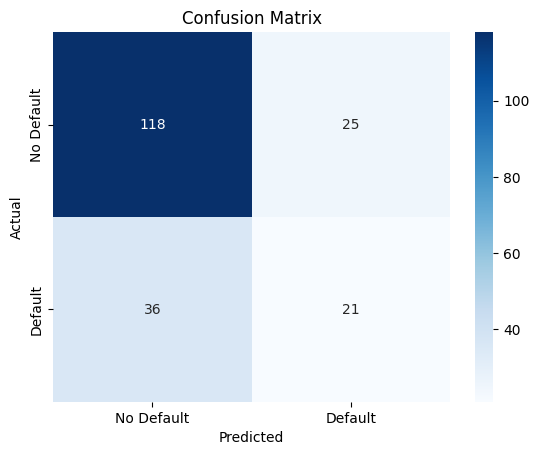

In [50]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
